# Visualizations in Plotly for the DMP Aspect Test Experiment

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append("../../")

from dmp.data.logging import _get_sql_engine
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from joblib import Memory
from ipywidgets import interact, interact_manual

import plotly.graph_objects as go

In [3]:
db = _get_sql_engine()

memory = Memory(location="./cache", verbose=0)

def query(query_string):
    with db.connect() as engine:
        return pd.read_sql(query_string, engine)

cached_query = memory.cache(query)

def clear_cache():
    memory.clear()
    
options = {
    "dataset": ['529_pollen',
        'sleep',
        'adult',
        '537_houses',
        'nursery',
        '201_pol',
        'mnist',
        'connect_4',
        'wine_quality_white'],
    "agg": ["avg", "min", "max"],
    "topology" : ["exponential", "rectangle", "trapezoid", "wide_first"],
    "loss": ['history_loss', 'history_hinge', 'history_accuracy',
       'history_val_loss', 'history_val_hinge', 'history_val_accuracy',
       'history_squared_hinge', 'history_cosine_similarity',
       'history_val_squared_hinge', 'history_mean_squared_error',
       'history_mean_absolute_error', 'history_val_cosine_similarity',
       'history_val_mean_squared_error', 'history_root_mean_squared_error',
       'history_val_mean_absolute_error',
       'history_kullback_leibler_divergence',
       'history_val_root_mean_squared_error',
       'history_mean_squared_logarithmic_error',
       'history_val_kullback_leibler_divergence',
       'history_val_mean_squared_logarithmic_error'],
    "residual_mode": ["none", "full"]
}

In [4]:
clear_cache()

# 3D Heatmap App

In [ ]:
@interact_manual(**options, viz=["imshow", "scatter"])
def heatmap_app_3d(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none", viz="imshow"):
    query_string = f'''
    select "config.budget", "config.depth", {agg}(a.val) as value, count(a.val), a.epoch
    from
        materialized_experiments_0 t,
        unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
    WHERE
        "groupname" IN {groups} and
        "config.dataset"='{dataset}' and
        "config.topology"='{topology}' and
        "config.residual_mode"='{residual_mode}'
    GROUP BY epoch, "config.budget", "config.depth"
    '''
    df = cached_query(query_string).query("count == 30")
    
    if viz=="scatter":
        
        fig = px.scatter_3d(df,
                    x='config.depth',
                    y='config.budget',
                    z='epoch',
                    color='value',
                    log_y=True,
                    opacity=0.25)
        fig.show()
        
    elif viz=="imshow":

        dimensions = ["config.budget", "config.depth", "epoch"]

        df[dimensions[0]] = df[dimensions[0]].astype(int)
        df[dimensions[1]] = df[dimensions[1]].astype(int)
        df[dimensions[2]] = df[dimensions[2]].astype(int)

        x_labels, y_labels, z_labels = [sorted(df[dim].unique()) for dim in dimensions]
        X, Y, Z = np.mgrid[0:len(x_labels), 0:len(y_labels), 0:len(z_labels)]
        values = np.empty((X+Y+Z).shape)
        values[:] = np.NaN

        x_idx = {a:b for b,a in enumerate(x_labels)}
        y_idx = {a:b for b,a in enumerate(y_labels)}
        z_idx = {a:b for b,a in enumerate(z_labels)}

        for _, row in df.iterrows():
            values[x_idx[row[dimensions[0]]], y_idx[row[dimensions[1]]], z_idx[row[dimensions[2]]]] = row["value"]


        fig = go.Figure(data=go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=values.flatten(),
            opacity=0.1, # needs to be small to see through all surfaces
            surface_count=30
            ))

        fig.update_layout(scene = dict(
                            xaxis = dict(ticktext=x_labels,
                                         tickvals=list(range(0,len(x_labels))),
                                         title=dimensions[0]),

                            yaxis = dict(ticktext=y_labels,
                                         tickvals=list(range(0,len(y_labels))),
                                         title=dimensions[1]),

                            zaxis = dict(ticktext=z_labels,
                                         tickvals=list(range(0,len(z_labels))),
                                         title=dimensions[2]),


                            ),
                          width=700, height=700,
                         title=f"{loss} for {dataset}, {topology}, residual {residual_mode}")
        fig.show()



# 2D Heatmap App

In [ ]:
### Heapmap App using Imshow

@interact_manual(**options, viz=["imshow", "scatter"])
def heatmap_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none", viz="imshow"):
    query_string = f'''
select "config.budget", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
GROUP BY epoch, "config.budget"
'''
    df = cached_query(query_string)
    
    if viz == "imshow":
        #df = df.query("count > 389")
        df["value"] = np.log(df["value"])
        img = df.pivot_table(columns="epoch", index="config.budget", values="value")
        img.index = img.index.astype("str") #plotly interprets the y axis as numeric otherwise
        return px.imshow(img)
    elif viz == "scatter":
        df = df.sort_values(["epoch", "config.budget"], ascending=[True, False])
        df["config.budget"] = df["config.budget"].astype("str")
        df["epoch"] = df["epoch"].astype("str")
        return px.scatter(df, x="epoch", y="config.budget", size="count", color="value")

## Choose Your Axis Heatmap Plot

In [ ]:
### Heapmap App using Imshow

axis = ["dataset", "topology", "residual_mode", "budget"]

@interact_manual(**options, viz=["imshow", "scatter"], y_dim=axis)
def heatmap_app(groups="('exp00', 'exp01')", x_dim="epoch", y_dim="budget", budget="64", dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none", viz="imshow"):
    axis = ["dataset", "topology", "residual_mode", "budget"]
    args = locals()
    filter_string = " and ".join([f'''"config.{s}"='{args[s]}' ''' for s in axis if s != y_dim])
    query_string = f'''
select "config.{y_dim}", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    {filter_string}
GROUP BY {x_dim}, "config.{y_dim}"
'''
    df = cached_query(query_string)
    
    if viz == "imshow":
        #df = df.query("count > 389")
        img = df.pivot_table(columns=x_dim, index="config."+y_dim, values="value")
        img.index = img.index.astype("str") #plotly interprets the y axis as numeric otherwise
        return px.imshow(img)
    elif viz == "scatter":
        df = df.sort_values(["epoch", "config.budget"], ascending=[True, False])
        df["config.budget"] = df["config.budget"].astype("str")
        df["epoch"] = df["epoch"].astype("str")
        return px.scatter(df, x="epoch", y="config.budget", size="count", color="value")

# Line Plot for Single budget x dataset x topology

In [ ]:
### single run app

@interact(**options)
def heatmap_app(dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none",
               budget="256"):
    query_string = f'''
select a.val as value, a.epoch, run_name
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN ('exp00', 'exp01') and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}' and
    "config.budget"='{budget}'
'''
    df = cached_query(query_string)
    return px.line(df, x="epoch", y="value", color="run_name")

##

- 537 houses, (val) kl divergence, trapezoid
- sleep, trapezoid, history_val_loss, 16777216

Notes:
- Logarithmic color map
- look into why sleep runs crash for high budgets
- plateau effect
- review stopping configurations / what is reasonable number of iterations?

# Next Steps

## Look at "plateau" feature from Charle's notebooks
## Add dataset, dataset complexity, as axis
## Add topology as an axis
### learning rate / optimizers / other axis to add

# To re-run using fixed epoch length, how long is reasonable?

In [ ]:
### Heapmap App using Imshow

@interact_manual(**options, viz=["imshow", "scatter"])
def heatmap_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    avg(array_length(t.history_loss, 1)) as avg,
    min(array_length(t.history_loss, 1)) as min,
    max(array_length(t.history_loss, 1)) as max,
    stddev(array_length(t.history_loss, 1)) as std
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
GROUP BY "config.budget"
'''
    df = cached_query(query_string).sort_values("config.budget")
    
    return px.line(df, x="config.budget", y="avg", error_y="std", log_x=True)

In [ ]:
### Epoch Count App

@interact_manual(**options, viz=["imshow", "scatter"])
def epoch_count_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    array_length(t.history_loss, 1) as num_epochs
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
'''
    df = cached_query(query_string)
    df = df.sort_values("config.budget")
    df["config.budget"] = df["config.budget"].astype("str")
    
    return px.scatter(df, x="config.budget", y="num_epochs", title=f"Number of epochs for {dataset}, {topology} in {groups}")

In [ ]:
### Epoch Count App

@interact_manual(**options, viz=["imshow", "scatter"])
def epoch_count_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    "config.topology",
    array_length(t.history_loss, 1) as num_epochs
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.residual_mode"='{residual_mode}'
'''
    df = cached_query(query_string).sort_values("config.budget")
    
    df["config.budget"] = df["config.budget"].astype("str")
    
    return px.violin(df,
                    x="config.budget",
                    y="num_epochs",
                    color="config.topology",
                     box=True,
                    title=f"Number of epochs for {dataset}, in {groups}")

In [ ]:
### Epoch Count App

@interact_manual(**options, viz=["imshow", "scatter"])
def epoch_count_agg_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", residual_mode="none", viz="imshow"):
    query_string = f'''
select
    "config.budget",
    "config.dataset",
    array_length(t.history_loss, 1) as num_epochs
from
    materialized_experiments_0 t
WHERE
    "groupname" IN {groups} and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
'''
    df = cached_query(query_string).sort_values("config.budget")
    
    df["config.budget"] = df["config.budget"].astype("str")
    
    return px.violin(df,
                    x="config.budget",
                    y="num_epochs",
                    color="config.dataset",
                     box=True,
                    title=f"Number of epochs for {topology}, in {groups}")

In [ ]:
### Generate 90th percentile epoch length for each experiment
query_string = f'''
select
    (percentile_disc(0.9) within group (order by array_length(t.history_loss, 1))) as epoch_90_pctile,
    "config.topology",
    "config.residual_mode",
    "config.dataset",
    "config.budget"
FROM
    materialized_experiments_0 t
WHERE
    "groupname" IN ('exp00','exp01')
GROUP BY
    "config.topology",
    "config.residual_mode",
    "config.dataset",
    "config.budget"
'''

df = cached_query(query_string)

df

In [ ]:
### Generate 90th percentile epoch length for each experiment
query_string = f'''
    select
        max(array_length(t.history_loss, 1)) as epoch_max,
        (percentile_disc(0.90) within group (order by array_length(t.history_loss, 1))) as epoch_90_pctile,
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget"
    FROM
        materialized_experiments_0 t
    WHERE
        "groupname" IN ('exp00','exp01')
    GROUP BY
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget"
'''

df = cached_query(query_string)

df

,percentile,iterations,config.dataset,config.budget
0,479,467.65,201_pol,32
1,9357,9323.60,201_pol,64
2,7229,7014.35,201_pol,128
3,5964,5348.80,201_pol,256
4,4895,4240.60,201_pol,512
...,...,...,...,...
180,65,55.00,wine_quality_white,2097152
181,64,53.10,wine_quality_white,4194304
182,62,51.10,wine_quality_white,8388608
183,62,51.55,wine_quality_white,16777216


In [ ]:
df2 = df.groupby(["config.topology", "config.residual_mode", "config.dataset"]).max().drop("config.budget", axis=1)

df2.to_csv("epoch_90th_pctile.csv")
df2

In [ ]:
df.to_csv("epoch_90th_pctile_each_budget.csv")

,percentile,iterations,config.dataset,config.budget
0,479,467.65,201_pol,32
1,9357,9323.60,201_pol,64
2,7229,7014.35,201_pol,128
3,5964,5348.80,201_pol,256
4,4895,4240.60,201_pol,512
...,...,...,...,...
180,65,55.00,wine_quality_white,2097152
181,64,53.10,wine_quality_white,4194304
182,62,51.10,wine_quality_white,8388608
183,62,51.55,wine_quality_white,16777216


In [ ]:
## Now, we want to add dataset (or some statistic derived from the dataset's complexity) and topology as axis.

In [9]:
df = cached_query('''select * from materialized_experiments_0 WHERE "groupname" IN ('exp04') limit 10''')
display(df.columns)
df

Index(['id', 'name', 'timestamp', 'doc', 'job', 'groupname', 'jobid',
       'iterations', 'loss', 'num_classes', 'num_features', 'num_inputs',
       'num_observations', 'num_outputs', 'num_weights', 'run_name', 'task',
       'test_loss', 'val_loss', 'config.activation', 'config.budget',
       'config.dataset', 'config.depth', 'config.early_stopping.baseline',
       'config.early_stopping.min_delta', 'config.early_stopping.mode',
       'config.early_stopping.monitor', 'config.early_stopping.patience',
       'config.log', 'config.mode', 'config.name', 'config.num_hidden',
       'config.residual_mode', 'config.run_name', 'config.test_split',
       'config.topology', 'history_loss', 'history_hinge', 'history_accuracy',
       'history_val_loss', 'history_val_hinge', 'history_val_accuracy',
       'history_squared_hinge', 'history_cosine_similarity',
       'history_val_squared_hinge', 'history_mean_squared_error',
       'history_mean_absolute_error', 'history_val_cosine_similarit

,id,name,timestamp,doc,job,groupname,jobid,iterations,loss,num_classes,...,history_mean_absolute_error,history_val_cosine_similarity,history_val_mean_squared_error,history_root_mean_squared_error,history_val_mean_absolute_error,history_kullback_leibler_divergence,history_val_root_mean_squared_error,history_mean_squared_logarithmic_error,history_val_kullback_leibler_divergence,history_val_mean_squared_logarithmic_error


In [10]:
# Plot the heatmap of validation loss for one topology, one dataset, over iteration count and different budgets

q = '''
select "config.budget", avg(a.val) as val_loss, avg(a.loss) as train_loss, count(a.loss), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.history_val_mean_squared_error, t.history_mean_squared_error) WITH ORDINALITY as a(val, loss, epoch)
WHERE
    "groupname" IN ('exp00', 'exp01') and
    "config.dataset"='537_houses' and
    "config.topology"='wide_first' and
    "config.residual_mode"='none'
GROUP BY epoch, "config.budget"
'''

# q = '''
# select distinct("name")
# from
#     materialized_experiments_0
# WHERE
#     "groupname" IN ('exp00', 'exp01') and
#     "config.dataset"='537_houses' and
#     "config.topology"='wide_first' and
#     "config.residual_mode"='none' and
#     "config.budget"=262144
# limit 10
# '''

df = cache_query(q)
display(df.columns)
df

NameError: name 'cache_query' is not defined

In [5]:
### Generate max of 95th percentile epoch length and iterations to smallest loss over all topologies for each budget and dataset
query_string = f'''
select max(max_iterations) as max_iterations,
       max(p95) as p95,
       max(p90) as p90,
       max(p67) as p67,
       max(p50) as p50,
       max(p33) as p33,
       max(avg_iterations) as avg_iterations,
       max(foo.max_patience) as max_patience,
       min(foo.min_patience) as min_patience,
    foo."config.dataset",
    foo."config.budget"
--    foo."config.topology",
--    foo."config.residual_mode"
FROM
    (SELECT
        MAX(iterations) as max_iterations,
        (percentile_disc(0.95) within group (order by iterations ASC)) as p95,
        (percentile_disc(0.9) within group (order by iterations ASC)) as p90,
        (percentile_disc(0.67) within group (order by iterations ASC)) as p67,
        (percentile_disc(0.5) within group (order by iterations ASC)) as p50,
        (percentile_disc(0.33) within group (order by iterations ASC)) as p33,
        AVG(iterations) as avg_iterations,
        max("config.early_stopping.patience") as max_patience,
        min("config.early_stopping.patience") as min_patience,
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget",
        "config.depth"
    FROM
        materialized_experiments_0 t
    WHERE
        "groupname" IN ('exp00','exp01')
    GROUP BY
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget",
        "config.depth") AS foo
    GROUP BY
        foo."config.dataset",
        foo."config.budget"
--        foo."config.topology",
--        foo."config.residual_mode"
'''

df = cached_query(query_string)
display(df.columns)
df

Index(['max_iterations', 'p95', 'p90', 'p67', 'p50', 'p33', 'avg_iterations',
       'max_patience', 'min_patience', 'config.dataset', 'config.budget'],
      dtype='object')

,max_iterations,p95,p90,p67,p50,p33,avg_iterations,max_patience,min_patience,config.dataset,config.budget
0,1118,503,492,469,460,446,443.433333,10,10,201_pol,32
1,526,506,491,467,458,450,450.666667,10,10,201_pol,64
2,3419,3128,2701,2025,1471,1177,1567.300000,10,10,201_pol,128
3,2486,2113,1724,1365,1172,1080,1237.733333,10,10,201_pol,256
4,1852,1294,1229,1152,1029,930,1014.666667,10,10,201_pol,512
...,...,...,...,...,...,...,...,...,...,...,...
179,381,83,61,47,39,33,51.066667,10,10,wine_quality_white,2097152
180,87,73,61,45,38,32,40.500000,10,10,wine_quality_white,4194304
181,80,73,59,46,40,33,40.833333,10,10,wine_quality_white,8388608
182,75,69,62,54,48,44,48.766667,10,10,wine_quality_white,16777216


In [7]:
print(pd.unique(df['config.dataset']))
# print(pd.unique(df['config.topology']))

['201_pol' '529_pollen' '537_houses' 'adult' 'connect_4' 'mnist' 'nursery'
 'sleep' 'wine_quality_white']


In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

<IPython.core.display.Javascript object>


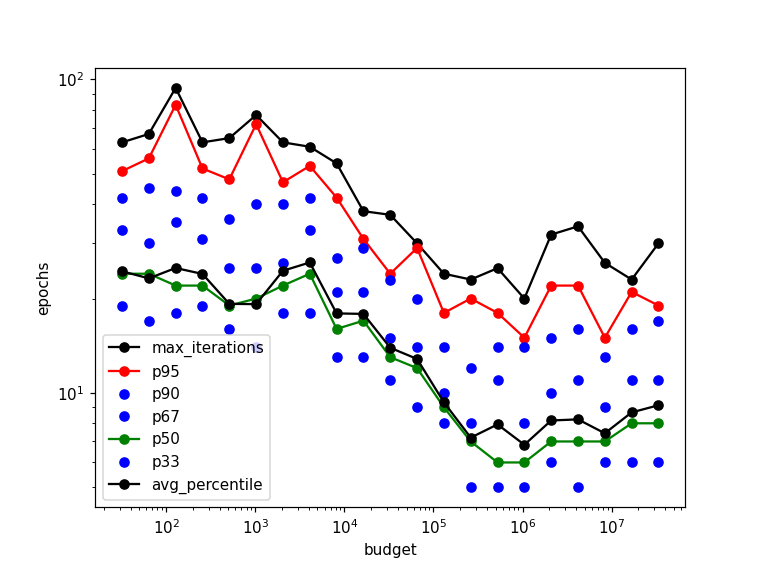

Text(0, 0.5, 'epochs')

In [9]:
dataset = 'connect_4'
filtered = df[df['config.dataset'] == dataset]
fig, ax = plt.subplots(1)
ax.plot(filtered['config.budget'], filtered['max_iterations'], 'ok-', label='max_iterations')
ax.plot(filtered['config.budget'], filtered['p95'], 'or-', label='p95')
ax.plot(filtered['config.budget'], filtered['p90'], 'ob', label='p90')
ax.plot(filtered['config.budget'], filtered['p67'], 'ob', label='p67')
ax.plot(filtered['config.budget'], filtered['p50'], 'og-', label='p50')
ax.plot(filtered['config.budget'], filtered['p33'], 'ob', label='p33')
ax.plot(filtered['config.budget'], filtered['avg_iterations'], 'o-k', label='avg_percentile')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('budget')
ax.set_ylabel('epochs')

<IPython.core.display.Javascript object>


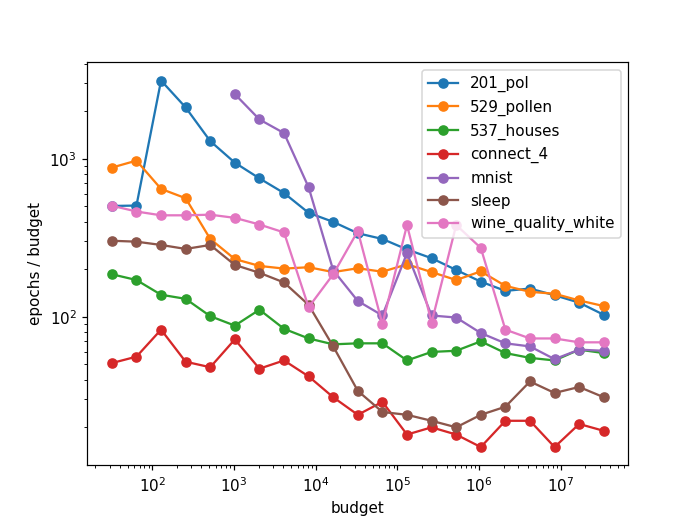

455
206
73
42
660
119
115


In [86]:
datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget']
    v = filtered['p95']
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
    ax.plot(budget, v, 'o-', label=dataset)
    print(filtered[filtered['config.budget'] == 8192]['p95'].iloc[0])
    
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
    ax.set_ylabel('epochs / budget')

In [21]:
from sklearn.linear_model import LinearRegression

for dataset in datasets:
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget']
    v = filtered['p95']
    x = np.log(budget)
    y = np.log(v/budget)
    X = np.reshape(x.to_numpy(), (len(x), 1))
    reg = LinearRegression().fit(X, y)
    print(f'{dataset} score: {reg.score(X, y)} coef: {reg.coef_} intercept: {reg.intercept_}')

201_pol score: 0.9924226029516098 coef: [-1.19362179] intercept: 7.950842974817022
529_pollen score: 0.9961419460769678 coef: [-1.12395313] intercept: 6.768707126612037
537_houses score: 0.9985539788252706 coef: [-1.07998381] intercept: 5.213180213125439
connect_4 score: 0.997318734115071 coef: [-1.11140072] intercept: 4.604741992826761
mnist score: 0.9824437459612909 coef: [-1.35547852] intercept: 9.536586601944183
sleep score: 0.9905921812530742 coef: [-1.21898858] intercept: 6.545592061968217
wine_quality_white score: 0.9908066504477884 coef: [-1.14709052] intercept: 6.875532030309655


<IPython.core.display.Javascript object>


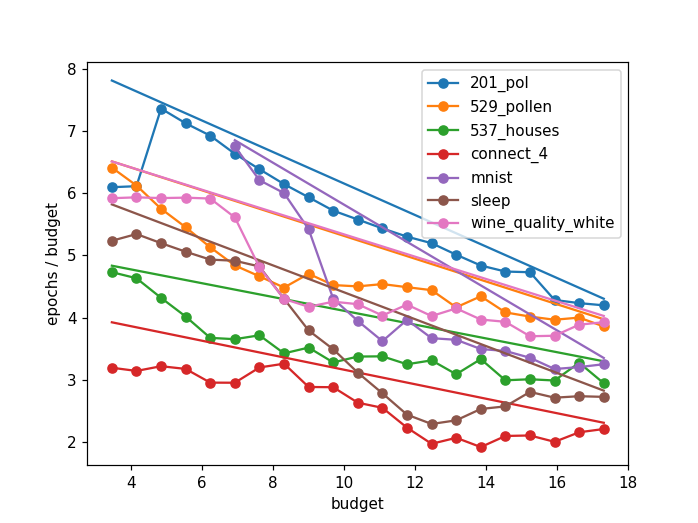

201_pol m: -0.2527556990577517 b: 8.683487973866393
529_pollen m: -0.1828880380176178 b: 7.143084069374159
537_houses m: -0.1107292366475284 b: 5.217925876091923
connect_4 m: -0.11638405390151485 b: 4.328712704770816
mnist m: -0.33632863634773813 b: 9.180441770802636
sleep m: -0.2157347864530791 b: 6.566251805499992
wine_quality_white m: -0.1789681721687238 b: 7.128522079859173


In [87]:
import scipy

def fit_above(x, y) :
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    x0, y0 = x[0] - 1, y[0]
    x -= x0
    y -= y0

    def error_function_2(b, x, y) :
        a = np.max((y - b) / x)
        return np.sum((y - a * x - b)**2)

    b = scipy.optimize.minimize(error_function_2, [0], args=(x, y)).x[0]

    a = np.max((y - b) / x)

    return a, b - a * x0 + y0

datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget'].to_numpy()
    v = filtered['avg_iterations'].to_numpy()
    x = np.log(budget)
#     x = 1.0 / budget
#     y = np.log(v)
#     y = np.log(v)
    y = np.log(v)
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
    p = ax.plot(x, y, 'o-', label=dataset)
    
#     X = np.reshape(x, (len(x), 1))
#     reg = LinearRegression().fit(X, y)
#     print(f'{dataset} score: {reg.score(X, y)} coef: {reg.coef_} intercept: {reg.intercept_}')
    
#     ax.plot(x, y, 'o-', label=dataset)
#     ax.plot(x, reg.coef_ * x + reg.intercept_, '-', color = p[0].get_color())
    
    m, b = fit_above(x,y)
    extra = .1
    b+=extra
    plt.plot(x, m*x + b, '-', color=p[0].get_color())
    print(f'{dataset} m: {m} b: {b}')
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)

#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
    ax.set_ylabel('epochs / budget')

<IPython.core.display.Javascript object>


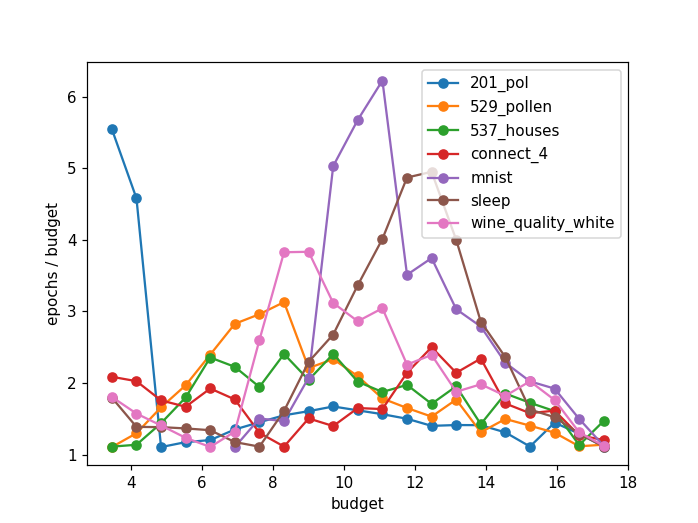

201_pol m: -0.2527556990577517 b: 8.683487973866393
dataset 201_pol [2459. 2064. 1733. 1454. 1221. 1025.  860.  722.  606.  509.  427.  358.
  301.  253.  212.  178.  150.  126.  105.   89.   74.]
529_pollen m: -0.1828880380176178 b: 7.143084069374159
dataset 529_pollen [672. 592. 521. 459. 405. 357. 314. 277. 244. 215. 189. 167. 147. 130.
 114. 101.  89.  78.  69.  61.  54.]
537_houses m: -0.1107292366475284 b: 5.217925876091923
dataset 537_houses [126. 117. 108. 100.  93.  86.  80.  74.  69.  64.  59.  55.  51.  47.
  43.  40.  37.  35.  32.  30.  28.]
connect_4 m: -0.11638405390151485 b: 4.328712704770816
dataset connect_4 [51. 47. 44. 40. 37. 34. 32. 29. 27. 25. 23. 21. 20. 18. 17. 16. 14. 13.
 12. 11. 11.]
mnist m: -0.33632863634773813 b: 9.180441770802636
dataset mnist [944. 747. 592. 469. 372. 294. 233. 185. 147. 116.  92.  73.  58.  46.
  37.  29.]
sleep m: -0.2157347864530791 b: 6.566251805499992
dataset sleep [337. 290. 250. 215. 186. 160. 138. 119. 102.  88.  76.  65.  56.  

In [90]:
import scipy

def fit_above(x, y) :
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    x0, y0 = x[0] - 1, y[0]
    x -= x0
    y -= y0

    def error_function_2(b, x, y) :
        a = np.max((y - b) / x)
        return np.sum((y - a * x - b)**2)

    b = scipy.optimize.minimize(error_function_2, [0], args=(x, y)).x[0]

    a = np.max((y - b) / x)

    return a, b - a * x0 + y0

datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget'].to_numpy()
    v = filtered['avg_iterations'].to_numpy()
    x = np.log(budget)
#     x = 1.0 / budget
#     y = np.log(v)
#     y = np.log(v)
    y = np.log(v)
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
#     p = ax.plot(x, y, 'o-', label=dataset)
    
#     X = np.reshape(x, (len(x), 1))
#     reg = LinearRegression().fit(X, y)
#     print(f'{dataset} score: {reg.score(X, y)} coef: {reg.coef_} intercept: {reg.intercept_}')
    
#     ax.plot(x, y, 'o-', label=dataset)
#     ax.plot(x, reg.coef_ * x + reg.intercept_, '-', color = p[0].get_color())
    
    m, b = fit_above(x,y)
    extra = .1
    b+=extra
#     plt.plot(x, m*x + b, '-', color=p[0].get_color())
    print(f'{dataset} m: {m} b: {b}')
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)
    bound = np.ceil(np.exp(m * np.log(budget) + b))
    p = ax.plot(x, bound/v , 'o-', label=dataset)
    print(f'dataset {dataset} {bound}')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
    ax.set_ylabel('epochs / budget')


<IPython.core.display.Javascript object>


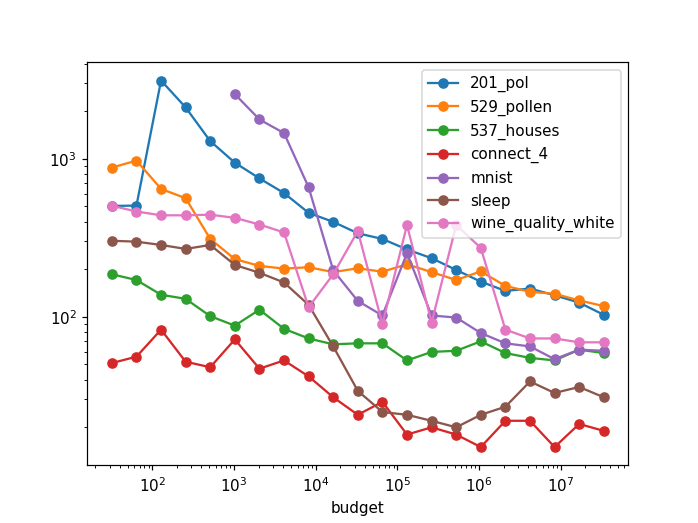

455
206
73
42
660
119
115


In [14]:
datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

fig, ax = plt.subplots(1)
for dataset in datasets:
#     if dataset != '529_pollen':
#         continue
#     filtered = df[(df['config.dataset'] == dataset) & (df['config.topology'] == 'trapezoid') & (df['config.residual_mode'] == 'none')]
    filtered = df[(df['config.dataset'] == dataset)]
    budget = filtered['config.budget']
    v = filtered['p95']
#     v = np.log10(v)
#     v_min = v.min()
#     v_max = v.max()
#     v_avg = v.mean()
#     v_std = v.std()
#     v_norm = (v - v_avg) / (v_std)
#     ax.plot(budget, v, 'o-', label=dataset)
    ax.plot(budget, v, 'o-', label=dataset)
    print(filtered[filtered['config.budget'] == 8192]['p95'].iloc[0])
    
#     ax.plot(budget, budget * filtered[], 'o-', label=dataset)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('budget')
#     ax.set_ylabel('epochs / budget')

In [40]:
query_string = f'''
    SELECT
        MAX(iterations) as max_iterations,
        (percentile_disc(0.95) within group (order by iterations ASC)) as p95,
        (percentile_disc(0.9) within group (order by iterations ASC)) as p90,
        (percentile_disc(0.67) within group (order by iterations ASC)) as p67,
        (percentile_disc(0.5) within group (order by iterations ASC)) as p50,
        (percentile_disc(0.33) within group (order by iterations ASC)) as p33,
        AVG(iterations) as avg_percentile,
        "config.dataset",
        "config.budget",
        max("config.early_stopping.patience") as max_patience,
        min("config.early_stopping.patience") as min_patience,
        "config.topology",
        "config.residual_mode"
    FROM
        materialized_experiments_0 t
    WHERE
        "groupname" IN ('exp00','exp01','exp02','exp05','exp06')
    GROUP BY
        "config.topology",
        "config.residual_mode",
        "config.dataset",
        "config.budget"
'''

df = cached_query(query_string)
display(df.columns)
df

Index(['max_iterations', 'p95', 'p90', 'p67', 'p50', 'p33', 'avg_percentile',
       'config.dataset', 'config.budget', 'max_patience', 'min_patience',
       'config.topology', 'config.residual_mode'],
      dtype='object')

,max_iterations,p95,p90,p67,p50,p33,avg_percentile,config.dataset,config.budget,max_patience,min_patience,config.topology,config.residual_mode
0,1118,441,321,292,286,278,281.192308,201_pol,32,10,10,exponential,none
1,496,444,344,291,285,278,283.748718,201_pol,64,10,10,exponential,none
2,2717,1290,644,293,285,278,386.212821,201_pol,128,10,10,exponential,none
3,2119,1091,963,301,289,280,399.138462,201_pol,256,10,10,exponential,none
4,1142,864,685,301,284,243,334.428205,201_pol,512,10,10,exponential,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,58,43,38,30,27,23,27.461538,wine_quality_white,2097152,10,10,wide_first,none
1103,53,39,36,29,26,22,25.966667,wine_quality_white,4194304,10,10,wide_first,none
1104,56,39,36,28,24,21,25.307692,wine_quality_white,8388608,10,10,wide_first,none
1105,62,41,36,28,24,21,24.943590,wine_quality_white,16777216,10,10,wide_first,none


<IPython.core.display.Javascript object>


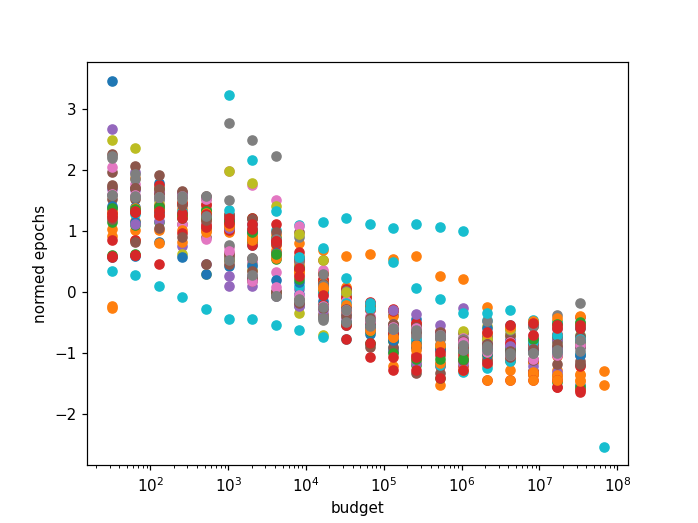

In [50]:
datasets = [d for d in pd.unique(df['config.dataset']) if d not in {'nursery', 'adult'}]

styles = ['']

fig, ax = plt.subplots(1)
for dataset in datasets:
    f1 = df[df['config.dataset'] == dataset]
    for topology in pd.unique(f1['config.topology']):
        filtered = f1[f1['config.topology'] == topology]
        v = filtered['p95']
        v = np.log(v)
        v_min = v.min()
        v_max = v.max()
        v_avg = v.mean()
        v_std = v.std()
        v_norm = (v - v_avg) / (v_std)
        ax.plot(filtered['config.budget'], v_norm, 'o', label=f'{dataset} {topology}')

    #     ax.set_yscale('log')
        ax.set_xscale('log')
#         ax.legend()
        ax.set_xlabel('budget')
        ax.set_ylabel('normed epochs')